# Physics Informed Neural Networks (PINN)

**Students:**

Guilherme Marim - RA: 232092

## Objective

Get a **PINN** to solve the Kuramoto-Sivashinsk equation.

Kuramoto-Sivashinsk equation: 

\begin{equation}
    u_{t} + uu_{x} + \alpha u_{xx} + \gamma u_{xxxx} = 0
\end{equation}

The dataset that will be used to solve this equation by the NN was obtained using the finite diference method and the initial condition was extracted of the bellow function:

\begin{equation}
    u(x,t=0) = cos(\frac{\pi x}{20})(1 - sin(\frac{\pi x}{20}))
\end{equation}

**This work was based on the following articles:**

1.	M. Raissi, P. Perdikaris, and G. E. Karniadakis, “Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations”, **arXiv**: 1711.10561v1, 28-Nov-2017.


2.	M. Raissi, P. Perdikaris, and G. E. Karniadakis, “Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations”, **arXiv**: 1711.10556v1, 28-Nov-2017.

## Loading Libraries

To develop this work, based on articles [1],[2], we used the 1.15 Tensorflow version.

In [1]:
!pip install tensorflow==1.15

In [2]:
!pip install pyDOE

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sympy import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler

np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
print(tf.__version__)

1.15.0


## Plot functions

In [5]:
def plot_data(X, T, U, title=''):
    fig, ax = plt.subplots(figsize=(9, 5))

    surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.xlabel('Space (x)')
    plt.ylabel('Time (t)')
    plt.tight_layout()

In [6]:
def plot_data_compare(X, T, U, U_reduced, title_1='Original data', title_2='Predicted data', title_3='Absolute difference'):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 7))
    
    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title(title_1)
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_reduced, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title(title_2)

    surf3 = ax[2].contourf(X, T, abs(U - U_reduced), cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title(title_3)

    plt.tight_layout()

    print(f'Mean error {round(abs(U - U_reduced).mean(), 2)}')

In [7]:
def plot_time_serie(u_original, time=0):
    plt.figure(figsize=(15, 4))
    plt.title("Time serie")
    plt.plot(u_original[time,:], linewidth = 3)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()

In [8]:
def plot_time_serie_compare(u_original, u_predicted, time=0):
    plt.figure(figsize=(15, 4))
    plt.title("Time serie")
    plt.plot(u_original[time,:], linewidth = 3, label="Original")
    plt.plot(u_predicted[time,:], '--r', linewidth = 3, label="Predicted")
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.show()

## Normalizarion function

In [9]:
# Normalize data
def normalize(X):    
    Xn = MinMaxScaler().fit_transform(X)
    return Xn

## Loading Dataset Kuramoto-Sivashinsk

In [10]:
X = np.load('/content/Kuramoto_X.npy')
T = np.load('/content/Kuramoto_T.npy')
U = np.load('/content/Kuramoto_U.npy')

(36000, 256)


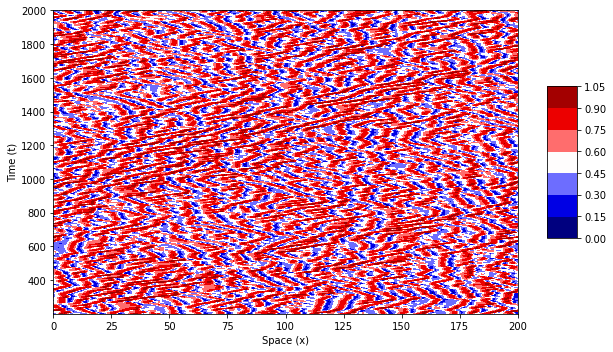

In [11]:
# Taking out the first 200 seconds
U = U[4001:,:]
X = X[4001:,:]
T = T[4001:,:]

print(U.shape)

U = normalize(U)

plot_data(X, T, U)

(3000, 256)


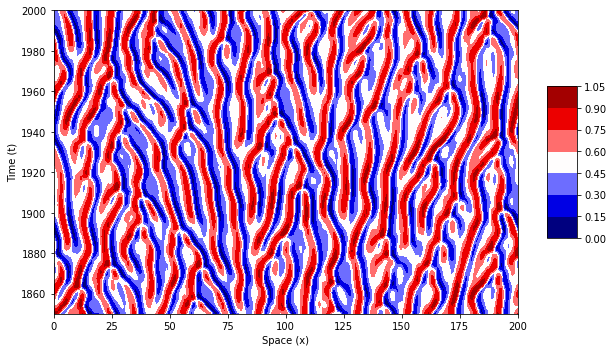

In [12]:
U_ = U[33000:,:]
X_ = X[33000:,:]
T_ = T[33000:,:]

print(U_.shape)

plot_data(X_, T_, U_)

In [13]:
print(U_.min(), U_.max())

0.0 1.0000000000000002


In [14]:
t = T_[:,0][:,None]
x = X_[0,:][:,None]

print(t.shape)
print(x.shape)
print(U_.shape)

(3000, 1)
(256, 1)
(3000, 256)


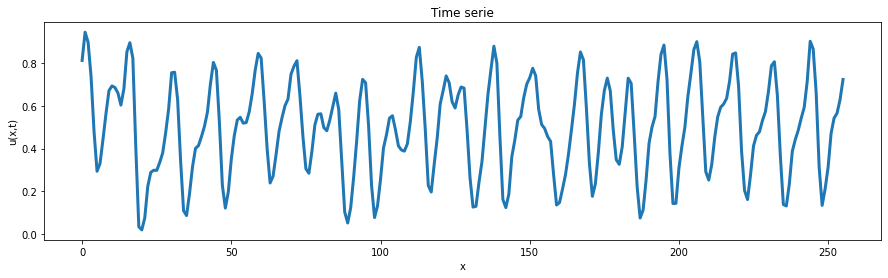

In [15]:
plot_time_serie(U_, time=10)

## Preparing input and output data for neural network training

In [16]:
X_star = np.hstack((X_.flatten()[:,None], T_.flatten()[:,None]))
u_star = U_.flatten()[:,None]

print(X_star.shape)
print(u_star.shape)

(768000, 2)
(768000, 1)


In [17]:
# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

print(lb)
print(ub)

[   0.   1850.05]
[ 200. 2000.]


## Initial e boundary conditions points and collocation points

For the training data we use $N_u = 300$ randomly distributed points on initial and
boundary conditions, and $N_r = 10.000$ collocation points for the residual term, sampled randomly over the interior of
the domain $x \in [0,1], t \in [0,1]$.

In [18]:
N_u = 300
N_f = 10000

In [19]:
xx1 = np.hstack((X_[0:1,:].T, T_[0:1,:].T))
uu1 = U_[0:1,:].T
xx2 = np.hstack((X_[:,0:1], T_[:,0:1]))
uu2 = U_[:,0:1]
xx3 = np.hstack((X_[:,-1:], T_[:,-1:]))
uu3 = U_[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


print(X_u_train.shape)
print(u_train.shape)
print(X_f_train.shape)

(300, 2)
(300, 1)
(16256, 2)


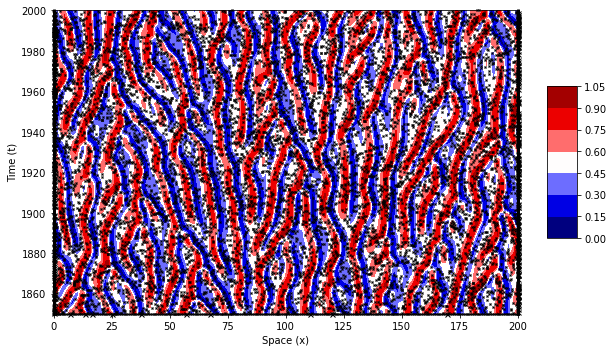

In [20]:
fig, ax = plt.subplots(figsize=(9, 5))

surf = ax.contourf(X_, T_, U_, cmap=plt.get_cmap("seismic"))
ax.plot(X_u_train[:,0], X_u_train[:,1], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 5, clip_on = False)
ax.plot(X_f_train[:,0], X_f_train[:,1], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.tight_layout()

## Creating the PINN class to make the training

For this work will be used two optimizers. The Adam optimizer in the first step and after the L-BFGS-B optimizer.

In [21]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, alpha, gama):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.alpha = alpha
        self.gama = gama
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.saver = tf.train.Saver()

        init = tf.global_variables_initializer()
        self.sess.run(init)

                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)

        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]
        u_xxxx = tf.gradients(u_xxx, x)[0]

        f = u_t + u*u_x + self.alpha*u_xx + + self.gama*u_xxxx
        
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):

        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % (it, loss_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        
        # Save the variables to disk.
        save_path = saver.save(sess, "/content/model_ks.ckpt")

    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

## Training the model

We use to train the model the architecture proposed by the article[1], with 8 deep layers with 20 neurons each, the input layer inputting the space and time data, and the output layer outputting the value of the U function

In [22]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

alpha = 1
gama = 1

In [23]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, gama)
    
start_time = time.time()                
model.train(30000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

A saída de streaming foi truncada nas últimas 5000 linhas.
Loss: 5.6819164e-05
Loss: 5.6812074e-05
Loss: 5.680816e-05
Loss: 5.680147e-05
Loss: 5.6796827e-05
Loss: 5.6789257e-05
Loss: 5.678307e-05
Loss: 5.6780736e-05
Loss: 5.6772467e-05
Loss: 5.6770157e-05
Loss: 5.6767185e-05
Loss: 5.6770346e-05
Loss: 5.6765595e-05
Loss: 5.6762736e-05
Loss: 5.6758217e-05
Loss: 5.675497e-05
Loss: 5.674968e-05
Loss: 5.674916e-05
Loss: 5.6747238e-05
Loss: 5.6742778e-05
Loss: 5.67385e-05
Loss: 5.673627e-05
Loss: 5.6729303e-05
Loss: 5.671874e-05
Loss: 5.6731453e-05
Loss: 5.6714256e-05
Loss: 5.670502e-05
Loss: 5.670038e-05
Loss: 5.6697525e-05
Loss: 5.6695397e-05
Loss: 5.6688907e-05
Loss: 5.6682966e-05
Loss: 5.667818e-05
Loss: 5.6675675e-05
Loss: 5.6670284e-05
Loss: 5.6673394e-05
Loss: 5.6668116e-05
Loss: 5.6664117e-05
Loss: 5.6656834e-05
Loss: 5.665033e-05
Loss: 5.6643854e-05
Loss: 5.6634417e-05
Loss: 5.6651104e-05
Loss: 5.663121e-05
Loss: 5.6625297e-05
Loss: 5.6623478e-05
Loss: 5.662228e-05
Loss: 5.6616755e-

NameError: ignored

In [24]:
X_star.shape

(768000, 2)

In [25]:
u_pred, f_pred = model.predict(X_star)
        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X_, T_), method='cubic')
Error = np.abs(U_ - U_pred)

Error u: 4.461394e-01


Mean error 0.2


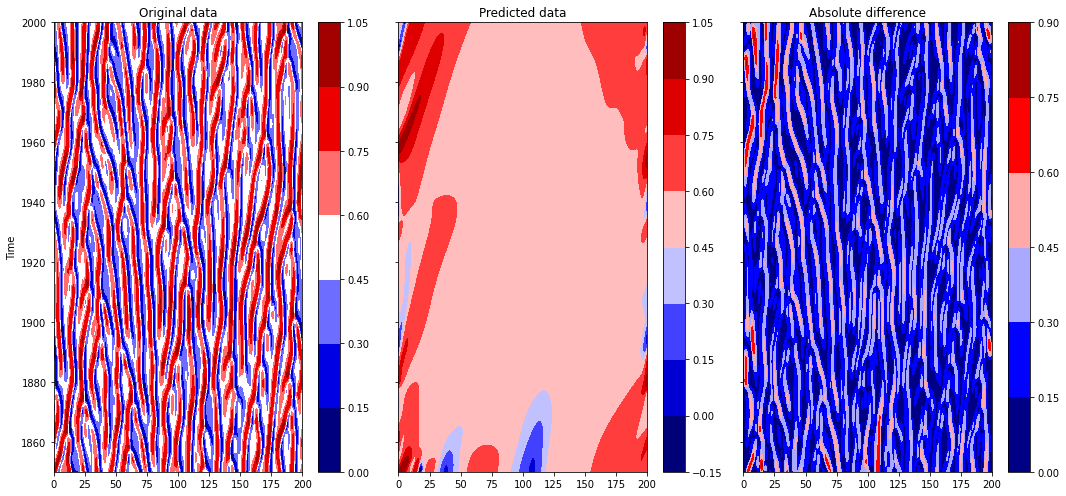

In [26]:
plot_data_compare(X_, T_, U_, U_pred)

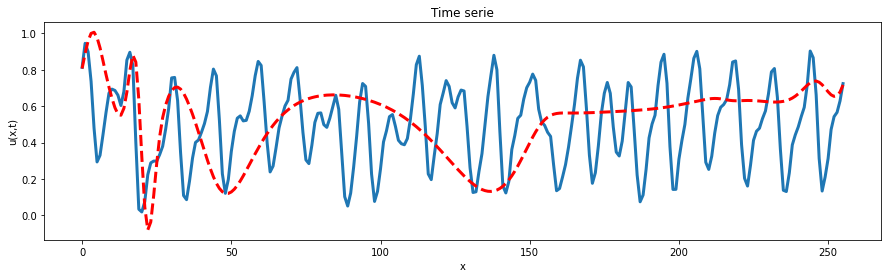

In [27]:
plot_time_serie_compare(U_, U_pred, time=10)